# Authorship Analysis

This Jupyter notebook uses statistical methods to analyze the authorship of a text. The text is split into words, and the frequency of each word is calculated. The frequency of each word is then compared to the frequency of the same word in a training set of texts of known authorship. The authorship of the text is then predicted based on the similarity of the word frequencies.

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk

import os
import sys
from typing import List, Tuple, Dict, Callable, Union, Any, Optional, Self

# Tokenization

The first step in the analysis is to tokenize the text. Tokenization is the process of splitting the text into words. The text is split into words using the `nltk` library.

# Frequency Analysis

The next step is to calculate the frequency of each word in the text. The frequency of each word is calculated by counting the number of times the word appears in the text and dividing by the total number of words in the text.

In [78]:
def tokenize(text: str) -> List[str]:
    '''
    Takes a string and returns a list of words.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
    
    Returns
    -------
    List[str]
        A list of words.
    '''
    # return nltk.word_tokenize(text)
    return text.split()

def word_count(text: str) -> int:
    '''
    Takes a string and returns the number of words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of words in the text.
    '''
    return len(tokenize(text))

def word_count_map(text: str) -> Dict[str, int]:
    '''
    Takes a string and returns a dictionary of words and their counts.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, int]
        A dictionary of words and their counts.
    '''
    return {word: text.count(word) for word in tokenize(text)}

def word_freq(text: str) -> Dict[str, float]:
    '''
    Takes a string and returns a dictionary of words and their frequencies.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of words and their frequencies.
    '''
    wc = word_count(text)
    return {word: count / wc for word, count in word_count_map(text).items()}


# Corpus

This implements an abstraction for managing a corpus of texts. The corpus is a collection of texts, each of which has an author and a title. The corpus can be used to train a model to predict the authorship of a text.

In [79]:
class Corpus:
    '''
    A class to represent a corpus of text data.
    
    This provides abstractions for managing text data, including:
    - reading data from files
    - managing multiple works with separate metadata
    '''
    
    def __init__(self, name: str):
        '''
        Initialize a new Corpus object.
        
        Parameters
        ----------
        name : str
            The name of the corpus. This is used to identify the corpus, maybe used in plots, etc.
            Should be a short, descriptive name, that distinguishes this corpus from others.
        '''
        self.works = []
        self.name = name
        
    def add_work(self, title: str, author: str, text: str, **metadata):
        '''
        Add a new work to the corpus.
        
        Parameters
        ----------
        title : str
            The title of the work.
        author : str
            The author of the work.
        text : str
            The text of the work.
        metadata : dict
            Additional metadata about the work, such as publication date, genre, etc.
        '''
        self.works.append({'title': title, 'author': author, 'text': text, **metadata})
    
    def from_paths(name: str, paths: List[str], author: str, **metadata) -> Self:
        '''
        Load multiple works from files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        works = Corpus(name)
        for path in paths:
            with open(path, 'r') as f:
                text = f.read()
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            works.add_work(title, author, text, **metadata)
        return works
    
    def collate_texts(self) -> str:
        '''
        Combine all texts in the corpus into a single string.
        
        Returns
        -------
        str
            A single string containing all the text in the corpus.
        '''
        return ' '.join(work['text'] for work in self.works)
    
    def get_authors(self) -> List[str]:
        '''
        Get a list of authors in the corpus.
        
        Returns
        -------
        List[str]
            A list of the authors in the corpus.
        '''
        return [work['author'] for work in self.works]
    
    def get_titles(self) -> List[str]:
        '''
        Get a list of titles in the corpus.
        
        Returns
        -------
        List[str]
            A list of the titles in the corpus.
        '''
        return [work['title'] for work in self.works]
    
    def get_texts(self) -> List[str]:
        '''
        Get a list of texts in the corpus.
        
        Returns
        -------
        List[str]
            A list of the texts in the corpus.
        '''
        return [work['text'] for work in self.works]
    
    def get_works_by_author(self, author: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific author.
        
        Parameters
        ----------
        author : str
            The author to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works by the specified author.
        '''
        return [work for work in self.works if work['author'] == author]
    
    def get_works_by_title(self, title: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific title.
        
        Parameters
        ----------
        title : str
            The title to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works with the specified title.
        '''
        return [work for work in self.works if work['title'] == title]
    
    def get_works_by_metadata(self, **metadata) -> List[Dict[str, str]]:
        '''
        Get a list of works that match specific metadata criteria.
        
        Parameters
        ----------
        metadata : dict
            The metadata criteria to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works that match the specified metadata criteria.
        '''
        return [work for work in self.works if all(work[key] == value for key, value in metadata.items())]
    
    def get_word_counts_per_work(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their counts.
        '''
        return {work['title']: word_count_map(work['text']) for work in self.works}
    
    def get_word_counts(self) -> Dict[str, int]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, int]
            A dictionary of words and their counts in the entire corpus.
        '''
        return word_count_map(self.collate_texts())
    
    def get_word_freq_per_work(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        return {work['title']: word_freq(work['text']) for work in self.works}
    
    def get_word_freq(self) -> Dict[str, float]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, float]
            A dictionary of words and their frequencies in the entire corpus.
        '''
        return word_freq(self.collate_texts())
    
    def __repr__(self):
        return f'Corpus({self.name!r})'
    
    def __str__(self):
        return f'Corpus: {self.name} ({len(self.works)} works)'
    
    def __len__(self):
        return len(self.works)
    
    def __getitem__(self, idx: int) -> Dict[str, str]:
        return self.works[idx]
    
    def __iter__(self):
        return iter(self.works)
    
    def __contains__(self, title: str) -> bool:
        return any(title == work['title'] for work in self.works)
    
    def __add__(self, other: Self) -> Self:
        new = Corpus(f'{self.name} + {other.name}')
        new.works = self.works + other.works
        return new
    
    def __iadd__(self, other: Self) -> Self:
        self.works.extend(other.works)
        return self
    
    def __eq__(self, other: Self) -> bool:
        return self.name == other.name and self.works == other.works
    
    def __ne__(self, other: Self) -> bool:
        return not (self == other)
    
    def __bool__(self) -> bool:
        return bool(self.works)
    
    def __dir__(self) -> List[str]:
        return list(self.__dict__.keys()) + [work for work in self.works[0]]

In [80]:
# Load some texts into a corpus
corpus = Corpus.from_paths('Shakespeare', ['data/shakespeare/hamlet.txt', 'data/shakespeare/othello.txt', 'data/shakespeare/macbeth.txt', 'data/shakespeare/coriolanus.txt'], 'William Shakespeare', genre='tragedy')

print(corpus)



Corpus: Shakespeare (4 works)


{'Hamlet': {'THE': 6.258801439524332e-05, 'TRAGEDY': 3.129400719762166e-05, 'OF': 6.258801439524332e-05, 'HAMLET,': 3.129400719762166e-05, 'PRINCE': 3.129400719762166e-05, 'DENMARK': 3.129400719762166e-05, 'by': 0.0033171647629478954, 'William': 3.129400719762166e-05, 'Shakespeare': 3.129400719762166e-05, 'Dramatis': 3.129400719762166e-05, 'Personae': 3.129400719762166e-05, 'Claudius,': 6.258801439524332e-05, 'King': 0.005445157252386168, 'of': 0.022813331247066186, 'Denmark.': 0.0002190580503833516, 'Marcellus,': 0.00012517602879048663, 'Officer.': 3.129400719762166e-05, 'Hamlet,': 0.0008449381943357847, 'son': 0.0029729306837740573, 'to': 0.028070724456266623, 'the': 0.05182287591926146, 'former,': 3.129400719762166e-05, 'and': 0.02703802221874511, 'nephew': 0.00015647003598810827, 'present': 0.00031294007197621654, 'king.': 0.00012517602879048663, 'Polonius,': 0.00018776404318572994, 'Lord': 0.0008449381943357847, 'Chamberlain.': 3.129400719762166e-05, 'Horatio,': 0.0005007041151619

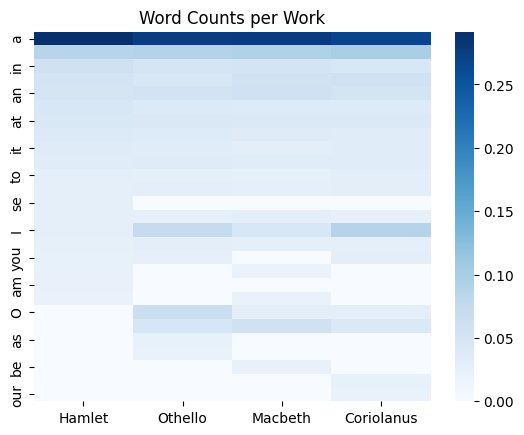

In [81]:
# Get the word counts for each work in the corpus
word_freq = corpus.get_word_freq_per_work()
print(word_freq)

# Get the top most common words in each work
top_word_freq = {work: {word: freq for word, freq in sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:20]} for work, freqs in word_freq.items()}
print(top_word_freq)

# Show a matrix of word counts for each work
df = pd.DataFrame(top_word_freq).fillna(0)
sns.heatmap(df, cmap='Blues')
plt.title('Word Counts per Work')
plt.show()